In [1]:
!pip install torchdiffeq systems


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from torchdiffeq import odeint
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler

os.makedirs("models", exist_ok=True)

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from systems.lotka_volterra import simulate as simulate_lv
from systems.lorenz import simulate as simulate_lorenz
from utils.compute_rsme import compute_rmse_over_time

/Users/siddharthaojha/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Neural ODE Model for Lotka-Volterra System
class LVNeuralODE(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )


    def forward(self, t, z):
        return self.net(z)

# Training loop
def train(model, t_eval, z_data, n_epochs=200, lr=0.01):
    scaler = StandardScaler()
    z_data_np = z_data.numpy()
    z_data_scaled = scaler.fit_transform(z_data_np)
    z_data_scaled = torch.tensor(z_data_scaled, dtype=torch.float32)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        z0 = z_data_scaled[0]
        z_pred = odeint(model, z0, t_eval, method='dopri5')
        loss = loss_fn(z_pred, z_data_scaled)
        loss.backward()
        optimizer.step()
        if epoch % (n_epochs // 10) == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
    return model, scaler

In [4]:
# Neural ODE model for 3D Lorenz system
class LZNeuralODE(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, t, z):
        return self.net(z)

# Training loop with normalization
def train(model, t_eval, z_data, n_epochs=2000, lr=1e-3):
    scaler = StandardScaler()
    z_data_np = z_data.numpy()
    z_data_scaled = scaler.fit_transform(z_data_np)
    z_data_scaled = torch.tensor(z_data_scaled, dtype=torch.float32)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        z0 = z_data_scaled[0]
        z_pred = odeint(model, z0, t_eval, method='dopri5')
        loss = loss_fn(z_pred, z_data_scaled)
        loss.backward()
        optimizer.step()
        if epoch % (n_epochs // 10) == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
    return model, scaler

In [5]:
def load_single_trajectory(npz_path, trajectory_index=0):
    """
    Loads a single trajectory and reshapes for PyDMD.
    Returns:
        - trajectory (n_features, n_time_steps)
        - initial condition (z0)
    """
    data = np.load(npz_path, allow_pickle=True)["trajectories"]
    traj_dict = data[trajectory_index]
    traj = traj_dict["traj"]
    z0 = traj_dict["z0"]
    t = traj_dict["t"]
    return traj, t, z0

In [6]:
def sample_arrows_by_distance(traj, min_dist):
    """Return indices where the distance from the last arrow exceeds min_dist."""
    arrow_indices = [0]
    last = traj[0]
    for i in range(1, len(traj)):
        dist = np.linalg.norm(traj[i] - last)
        if dist >= min_dist:
            arrow_indices.append(i)
            last = traj[i]
    return arrow_indices

## Use Neural ODE on Lotka-Volterra


=== Training on trajectory 1/10 ===
Epoch 0, Loss = 115.985664
Epoch 200, Loss = 1.110005
Epoch 400, Loss = 0.958083
Epoch 600, Loss = 0.935606
Epoch 800, Loss = 0.924692
Epoch 1000, Loss = 0.913522
Epoch 1200, Loss = 0.896414
Epoch 1400, Loss = 0.855007
Epoch 1600, Loss = 0.135686
Epoch 1800, Loss = 0.118513


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


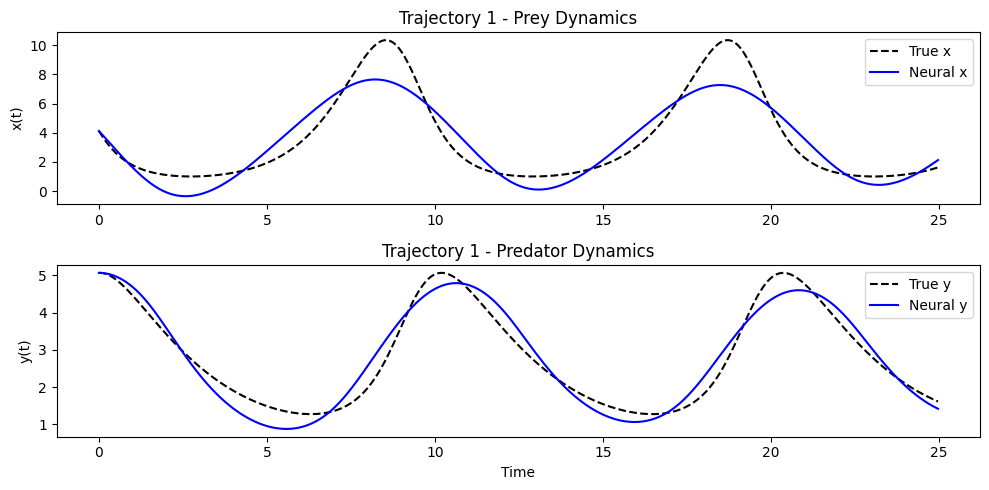

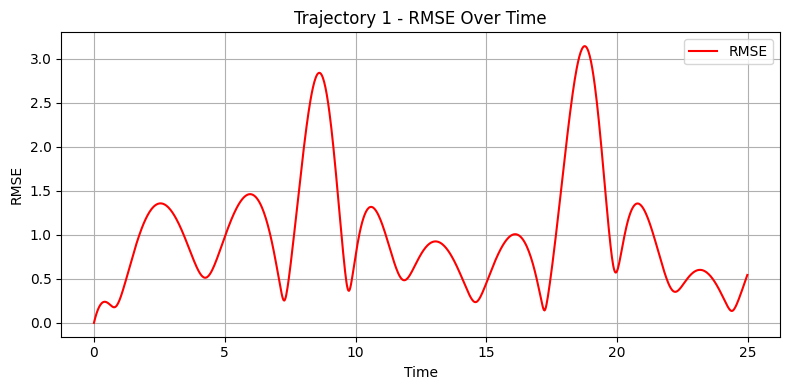


=== Training on trajectory 2/10 ===
Epoch 0, Loss = 3.663529
Epoch 200, Loss = 0.168031
Epoch 400, Loss = 0.125662
Epoch 600, Loss = 0.084751
Epoch 800, Loss = 0.053873
Epoch 1000, Loss = 0.039537
Epoch 1200, Loss = 0.027855
Epoch 1400, Loss = 0.022759
Epoch 1600, Loss = 0.019366
Epoch 1800, Loss = 0.016859


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


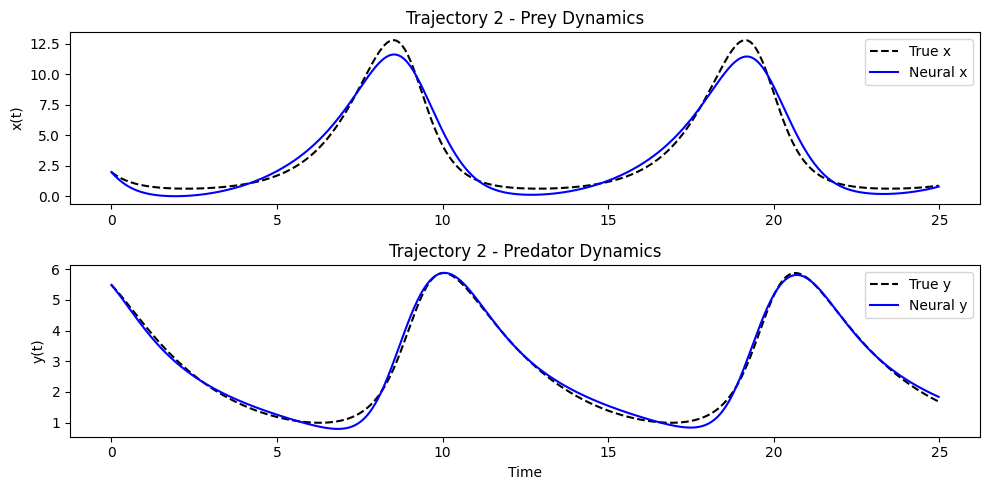

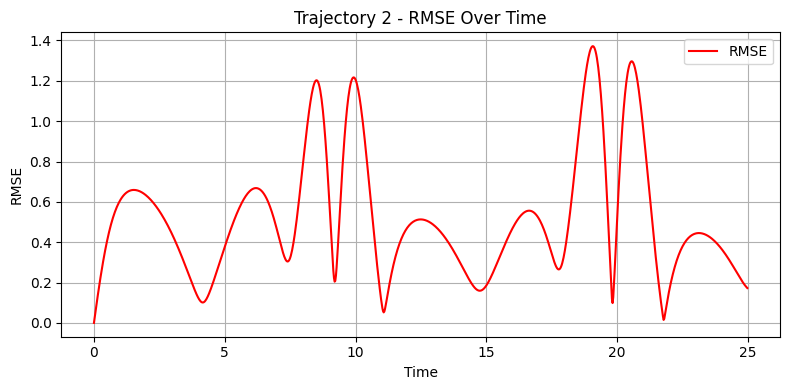


=== Training on trajectory 3/10 ===
Epoch 0, Loss = 8.433327
Epoch 200, Loss = 0.994929
Epoch 400, Loss = 0.980206
Epoch 600, Loss = 0.975376
Epoch 800, Loss = 0.973089
Epoch 1000, Loss = 0.970958
Epoch 1200, Loss = 0.967305
Epoch 1400, Loss = 0.973469
Epoch 1600, Loss = 0.971381
Epoch 1800, Loss = 0.968046


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


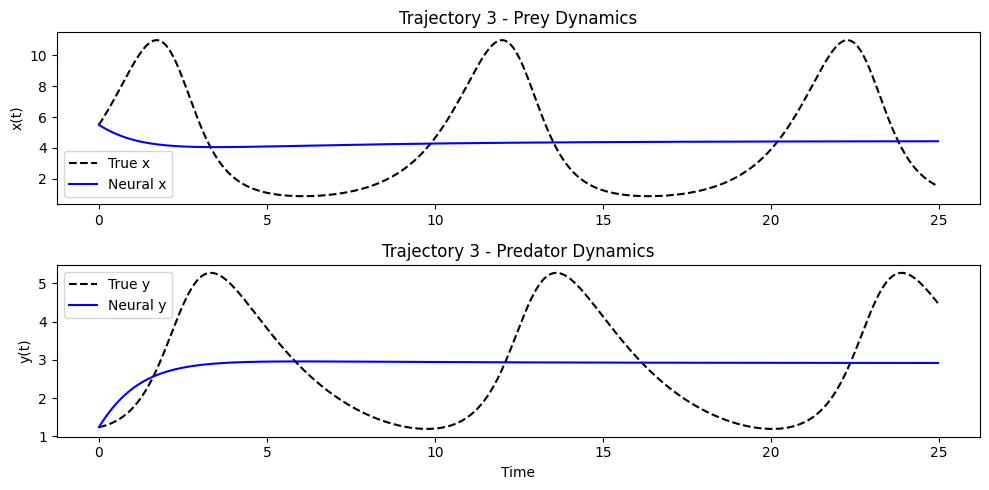

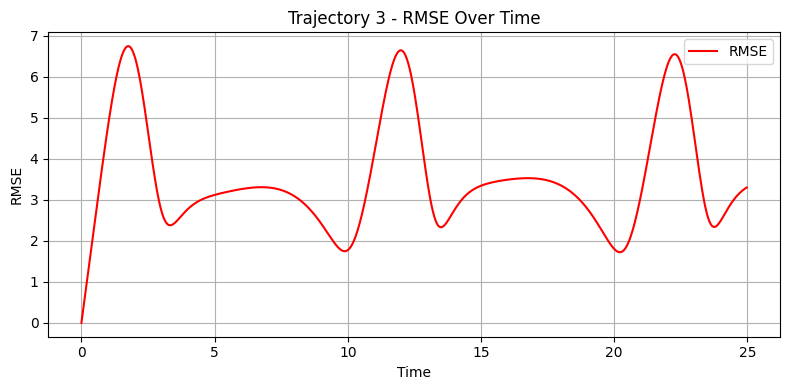


=== Training on trajectory 4/10 ===
Epoch 0, Loss = 4.526050
Epoch 200, Loss = 0.958343
Epoch 400, Loss = 0.875019
Epoch 600, Loss = 0.076255
Epoch 800, Loss = 0.051789
Epoch 1000, Loss = 0.035692
Epoch 1200, Loss = 0.022669
Epoch 1400, Loss = 0.013152
Epoch 1600, Loss = 0.007024
Epoch 1800, Loss = 0.003581


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


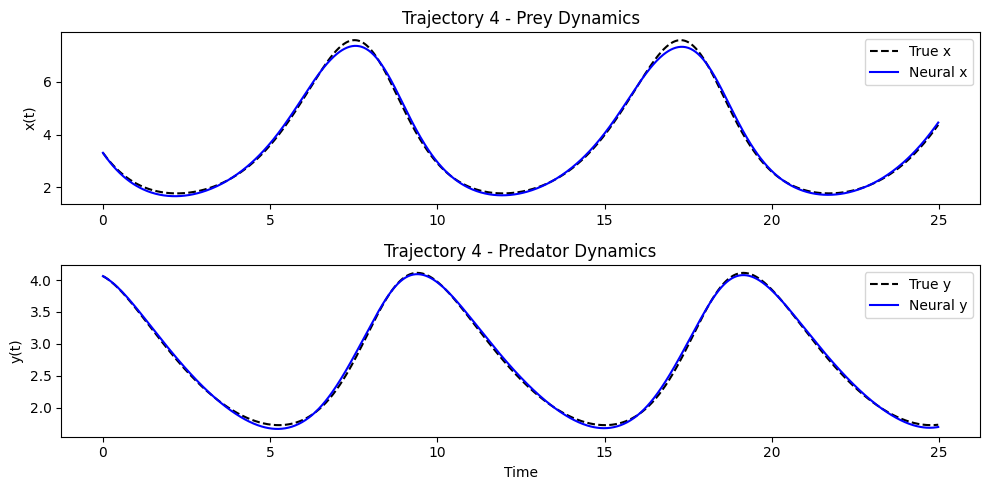

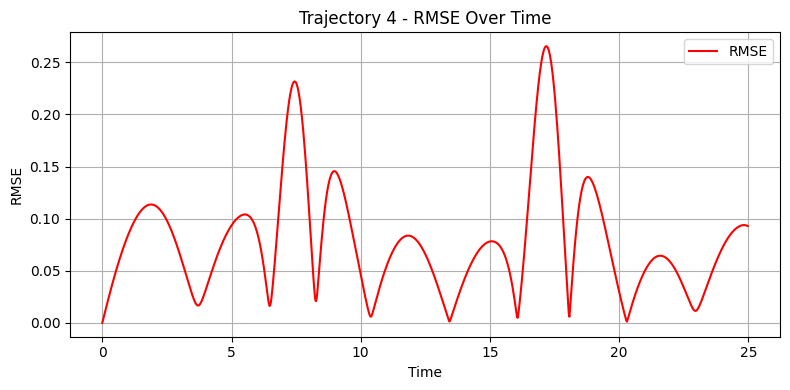


=== Training on trajectory 5/10 ===
Epoch 0, Loss = 18.796051
Epoch 200, Loss = 1.039105
Epoch 400, Loss = 1.012243
Epoch 600, Loss = 0.999027
Epoch 800, Loss = 0.991613
Epoch 1000, Loss = 0.987063
Epoch 1200, Loss = 0.984086
Epoch 1400, Loss = 0.982030
Epoch 1600, Loss = 0.980523
Epoch 1800, Loss = 0.979336


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


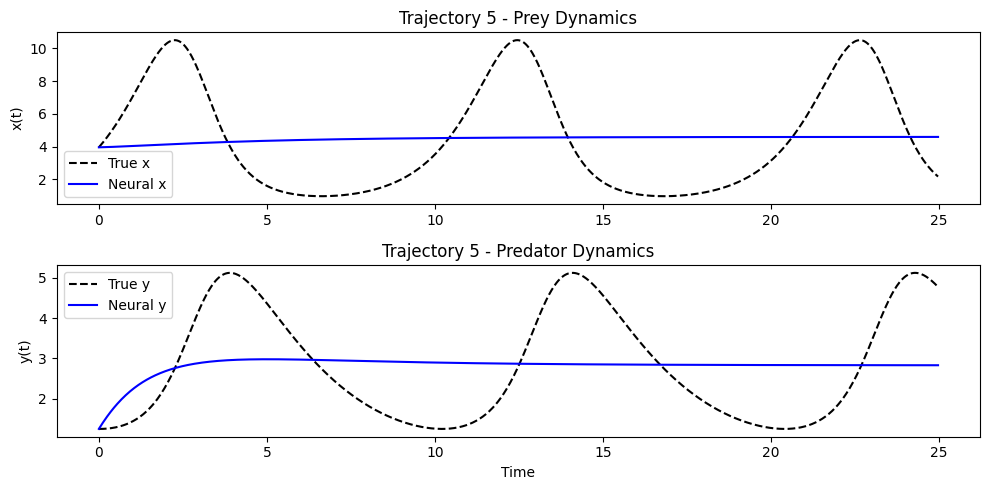

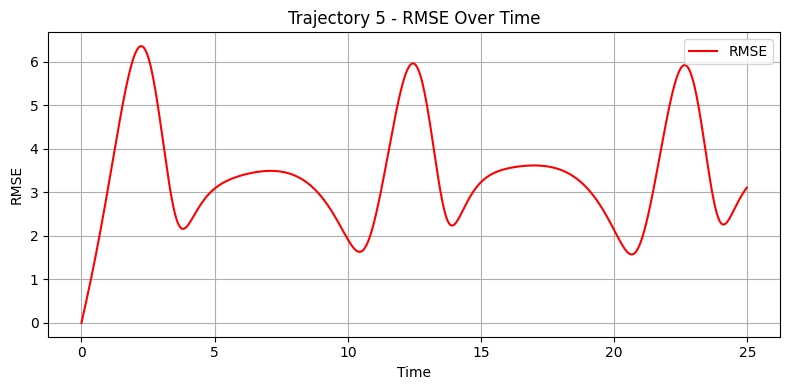


=== Training on trajectory 6/10 ===
Epoch 0, Loss = 19.527027
Epoch 200, Loss = 1.058889
Epoch 400, Loss = 1.008801
Epoch 600, Loss = 0.984907
Epoch 800, Loss = 0.971267
Epoch 1000, Loss = 0.962585
Epoch 1200, Loss = 0.956638
Epoch 1400, Loss = 0.952294
Epoch 1600, Loss = 0.948746
Epoch 1800, Loss = 0.944741


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


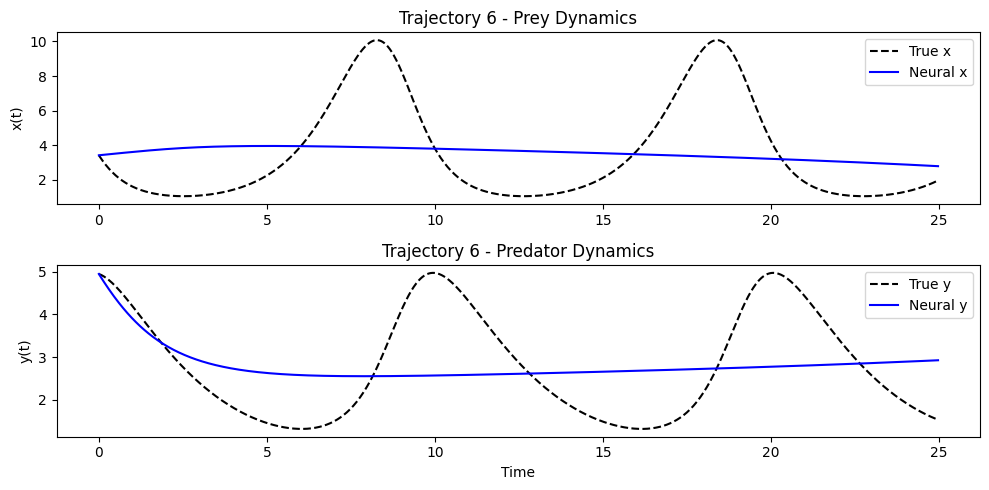

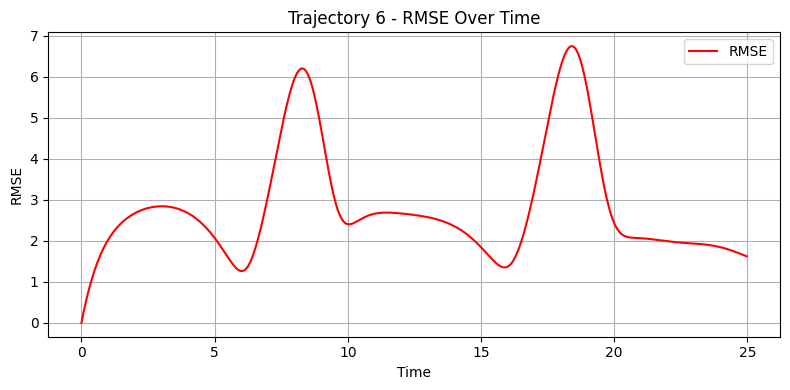


=== Training on trajectory 7/10 ===
Epoch 0, Loss = 93.044044
Epoch 200, Loss = 1.096850
Epoch 400, Loss = 1.053014
Epoch 600, Loss = 1.031864
Epoch 800, Loss = 1.015738
Epoch 1000, Loss = 1.003499
Epoch 1200, Loss = 0.994471
Epoch 1400, Loss = 0.987981
Epoch 1600, Loss = 0.983329
Epoch 1800, Loss = 0.979938


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


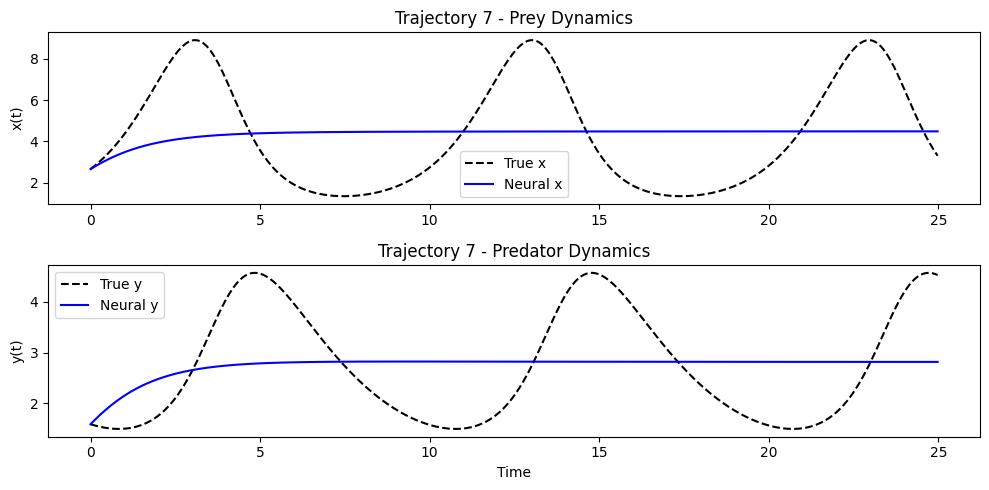

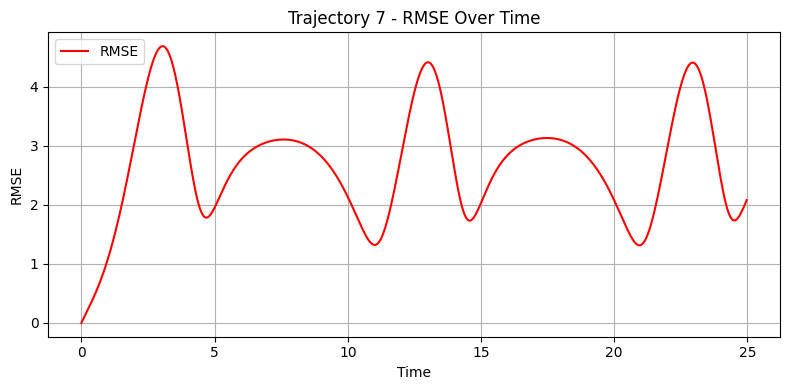


=== Training on trajectory 8/10 ===
Epoch 0, Loss = 21.855286
Epoch 200, Loss = 1.115530
Epoch 400, Loss = 1.024968
Epoch 600, Loss = 0.997730
Epoch 800, Loss = 0.984134
Epoch 1000, Loss = 0.975978
Epoch 1200, Loss = 0.969799
Epoch 1400, Loss = 0.961720
Epoch 1600, Loss = 0.958093
Epoch 1800, Loss = 0.962020


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


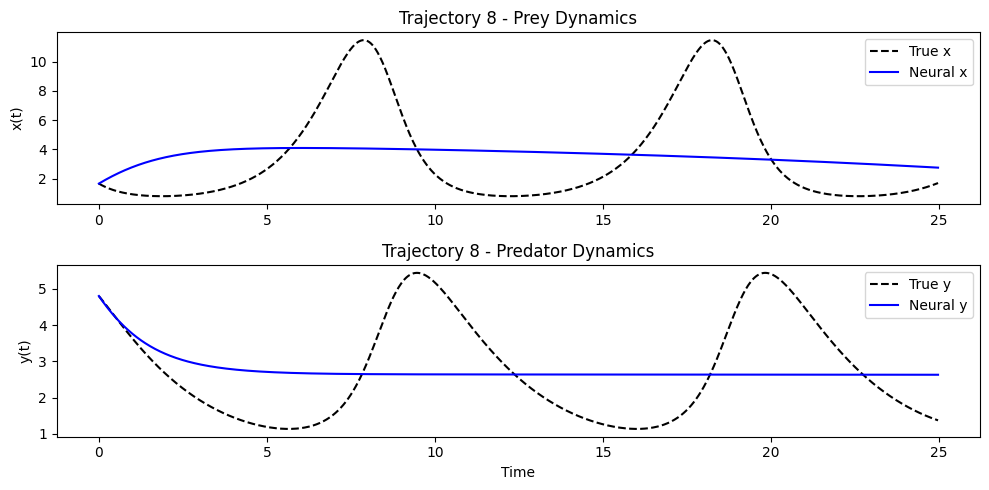

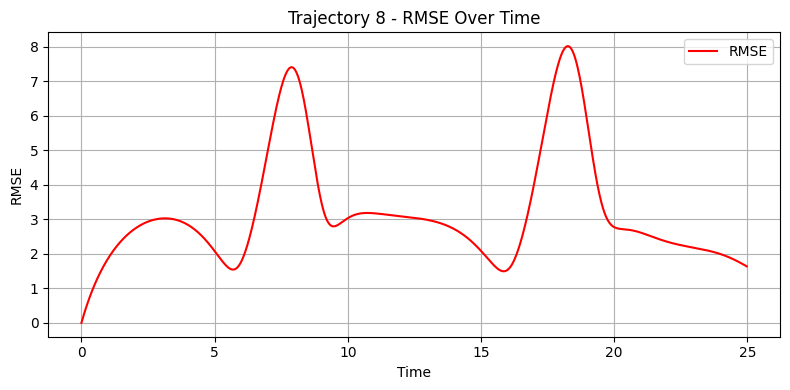


=== Training on trajectory 9/10 ===
Epoch 0, Loss = 31.753002
Epoch 200, Loss = 0.502860
Epoch 400, Loss = 0.011539
Epoch 600, Loss = 0.010461
Epoch 800, Loss = 0.009593
Epoch 1000, Loss = 0.008679
Epoch 1200, Loss = 0.007754
Epoch 1400, Loss = 0.006851
Epoch 1600, Loss = 0.005999
Epoch 1800, Loss = 0.005222


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


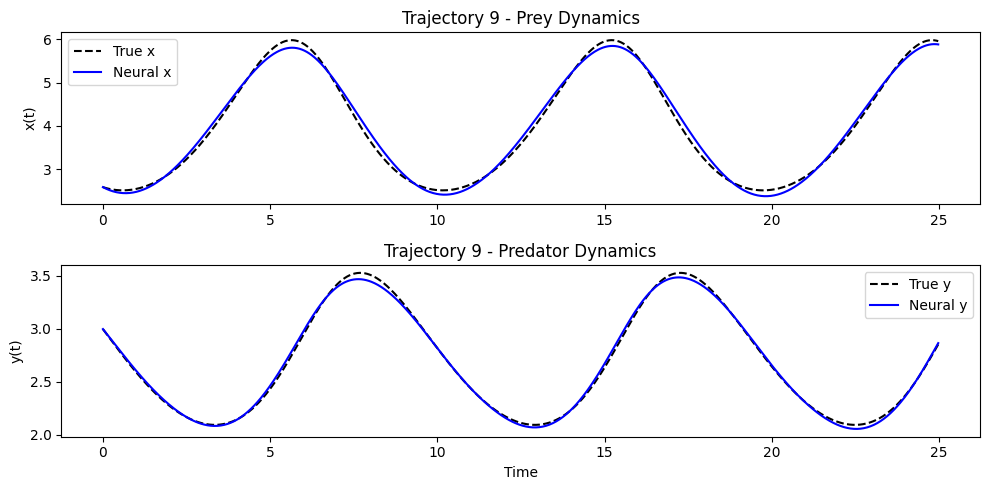

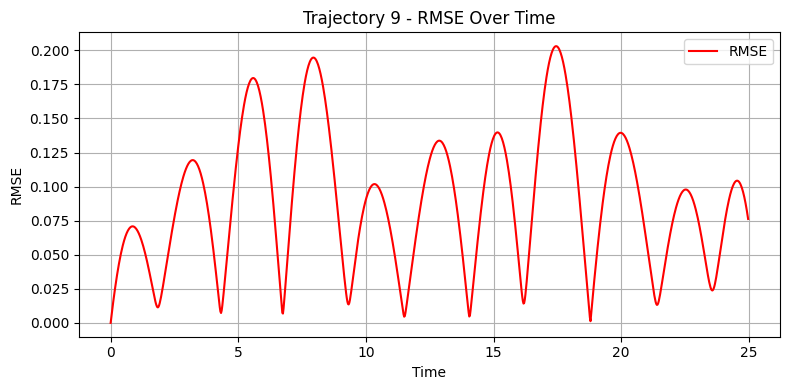


=== Training on trajectory 10/10 ===
Epoch 0, Loss = 13.678965
Epoch 200, Loss = 1.050941
Epoch 400, Loss = 0.978496
Epoch 600, Loss = 0.940304
Epoch 800, Loss = 0.906764
Epoch 1000, Loss = 0.857450
Epoch 1200, Loss = 0.170794
Epoch 1400, Loss = 0.075045
Epoch 1600, Loss = 0.055355
Epoch 1800, Loss = 0.041698


/var/folders/bh/rfktsbfx39ggqr2wkkqc79b80000gn/T/ipykernel_35478/3605030142.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


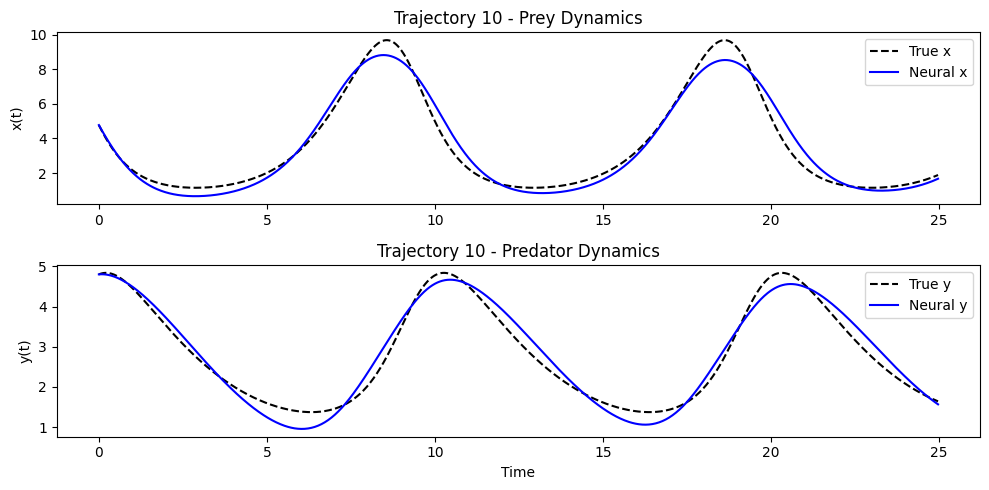

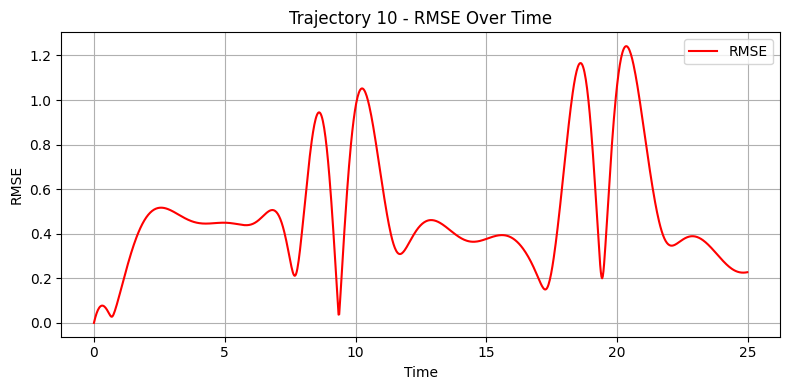

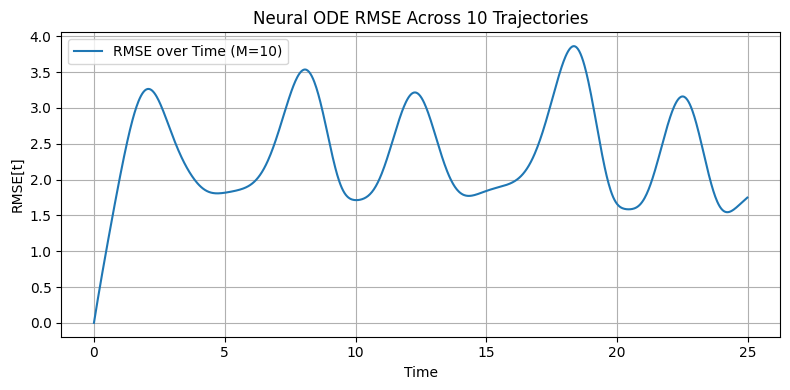

In [14]:
# Load entire dataset
all_data = np.load("data/lotka_volterra.npz", allow_pickle=True)["trajectories"]
M = len(all_data)
NUM_EPOCHS = 2000
LEARNING_RATE = 1e-3

true_trajectories = []
pred_trajectories = []

for i in range(M):
    print(f"\n=== Training on trajectory {i+1}/{M} ===")
    traj_data = all_data[i]
    
    z_data_np = traj_data["traj"]
    z0_np = traj_data["z0"]
    t_eval_np = traj_data["t"]

    z_data = torch.tensor(z_data_np, dtype=torch.float32)
    t_eval = torch.tensor(t_eval_np, dtype=torch.float32)

    # Define and train model
    model_neural = LVNeuralODE()
    trained_neural, scaler = train(model_neural, t_eval, z_data, n_epochs=NUM_EPOCHS, lr=LEARNING_RATE)

    model_path = f"models/lotka_volterra_neural_model_{i}.pt"
    torch.save({
        'model_state_dict': trained_neural.state_dict(),
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
    }, model_path)

    # Predict
    with torch.no_grad():
        z0_scaled = torch.tensor(scaler.transform(z_data[[0]].numpy()), dtype=torch.float32)[0]
        pred_neural_scaled = odeint(trained_neural, z0_scaled, t_eval, method='dopri5')
        pred_neural = torch.tensor(scaler.inverse_transform(pred_neural_scaled.numpy()), dtype=torch.float32)

    true_trajectories.append(z_data.numpy())
    pred_trajectories.append(pred_neural.numpy())

    # Plot comparison for this trajectory
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)

    axs[0].plot(t_eval.numpy(), z_data[:, 0], 'k--', label='True x')
    axs[0].plot(t_eval.numpy(), pred_neural[:, 0], 'b', label='Neural x')
    axs[0].set_ylabel("x(t)")
    axs[0].set_title(f"Trajectory {i+1} - Prey Dynamics")
    axs[0].legend()

    axs[1].plot(t_eval.numpy(), z_data[:, 1], 'k--', label='True y')
    axs[1].plot(t_eval.numpy(), pred_neural[:, 1], 'b', label='Neural y')
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("y(t)")
    axs[1].set_title(f"Trajectory {i+1} - Predator Dynamics")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # --- Compute and plot per-trajectory RMSE ---
    rmse_i = np.sqrt(np.sum((pred_neural.numpy() - z_data.numpy())**2, axis=1))  # shape: (T,)

    plt.figure(figsize=(8, 4))
    plt.plot(t_eval.numpy(), rmse_i, color='red', label='RMSE')
    plt.title(f"Trajectory {i+1} - RMSE Over Time")
    plt.xlabel("Time")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

rmse_t = compute_rmse_over_time(true_trajectories, pred_trajectories)

# ✅ Plot
plt.figure(figsize=(8, 4))
plt.plot(t_eval_np, rmse_t, label="RMSE over Time (M=10)")
plt.xlabel("Time")
plt.ylabel("RMSE[t]")
plt.title("Neural ODE RMSE Across 10 Trajectories")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save the RMSE and note that it is from the neural ODE model
np.savez("data/lotka_volterra_neural_rmse.npz", rmse=rmse_t, t=t_eval_np, label="Neural ODE")

## Use Neural ODE on Lorenz System


=== Lorenz Trajectory 1/10 ===
Epoch 0, Loss = 18.482555
Epoch 200, Loss = 0.947805
Epoch 400, Loss = 0.854078
Epoch 600, Loss = 0.810311
Epoch 800, Loss = 0.789105
Epoch 1000, Loss = 0.775487
Epoch 1200, Loss = 0.765723
Epoch 1400, Loss = 0.758207
Epoch 1600, Loss = 0.754149
Epoch 1800, Loss = 0.749041


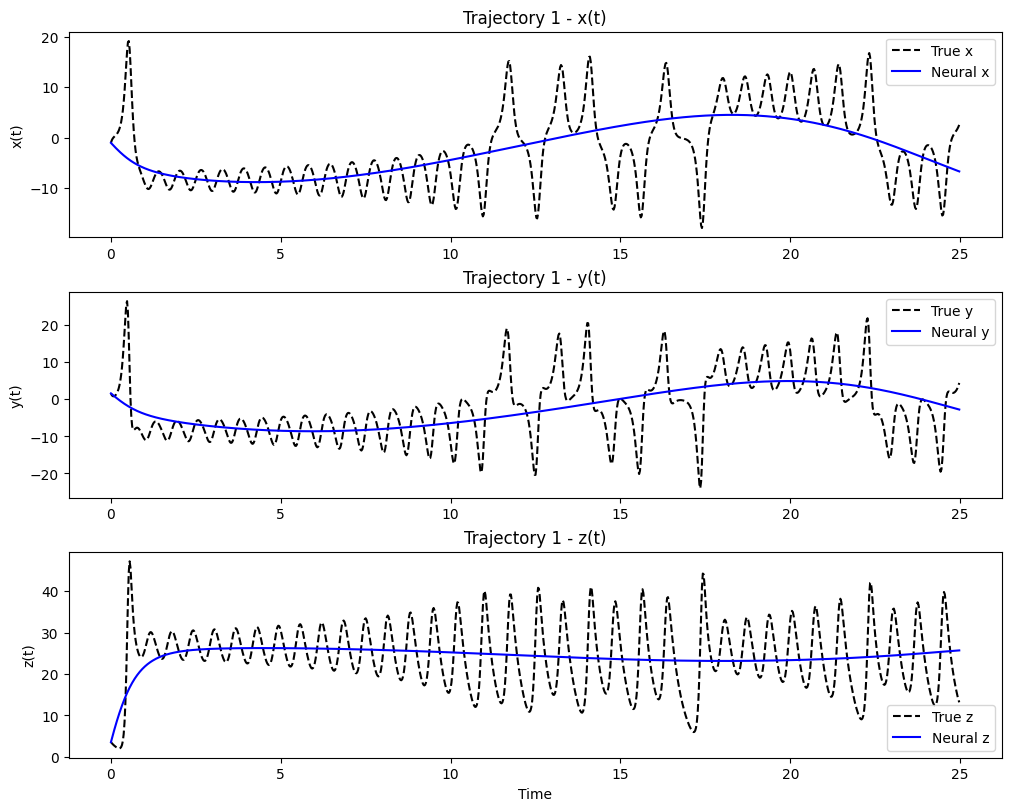

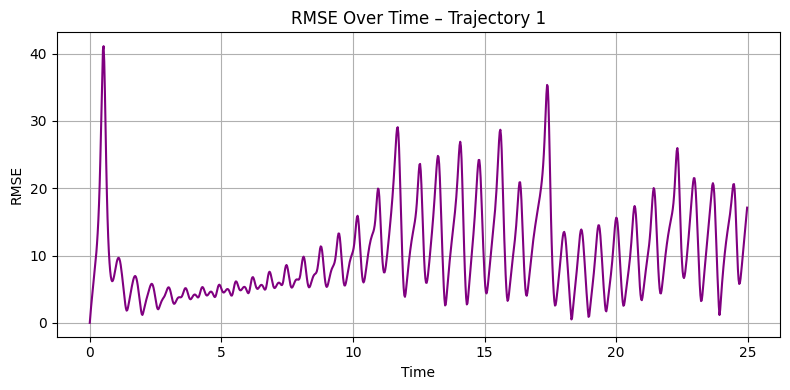

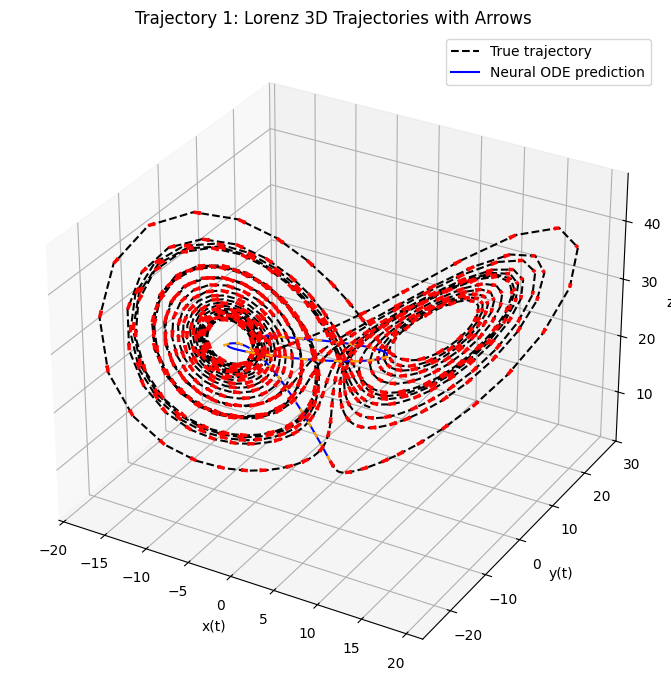


=== Lorenz Trajectory 2/10 ===
Epoch 0, Loss = 35.923531
Epoch 200, Loss = 1.156794
Epoch 400, Loss = 1.098622
Epoch 600, Loss = 1.067129
Epoch 800, Loss = 1.046119
Epoch 1000, Loss = 1.029275
Epoch 1200, Loss = 1.010697
Epoch 1400, Loss = 0.961379
Epoch 1600, Loss = 0.921192
Epoch 1800, Loss = 0.900179


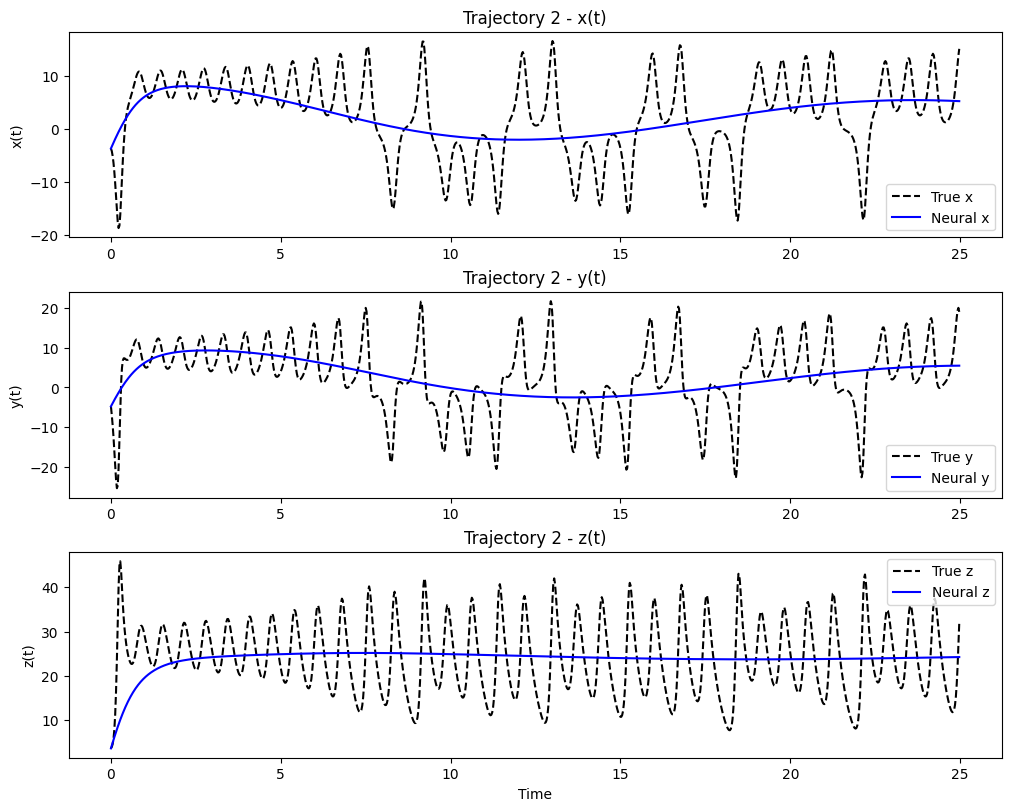

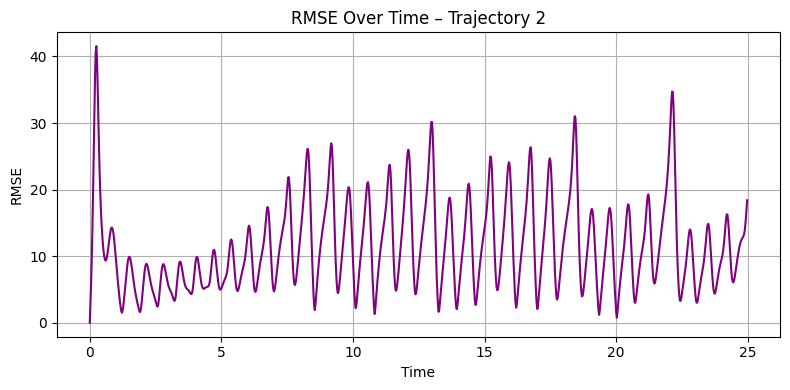

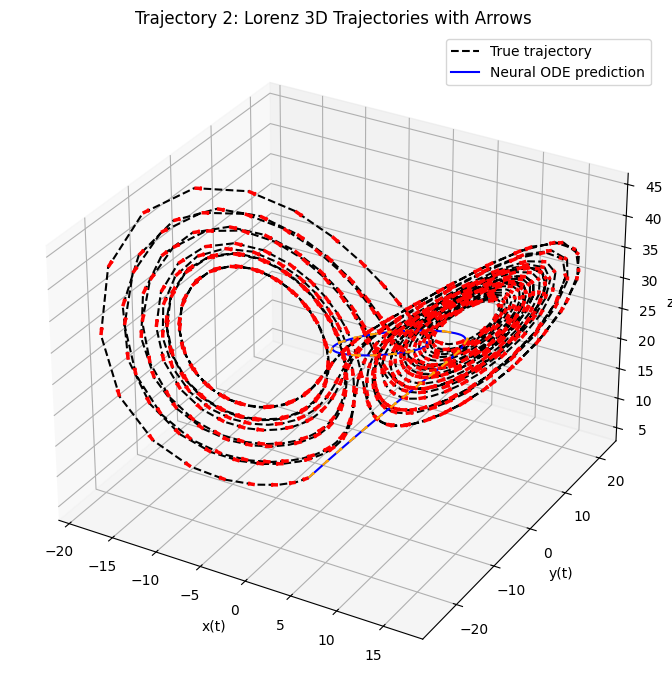


=== Lorenz Trajectory 3/10 ===
Epoch 0, Loss = 29.914015
Epoch 200, Loss = 1.103598
Epoch 400, Loss = 0.981158
Epoch 600, Loss = 0.932153
Epoch 800, Loss = 0.892240
Epoch 1000, Loss = 0.878170
Epoch 1200, Loss = 0.876221
Epoch 1400, Loss = 0.796826
Epoch 1600, Loss = 0.864865
Epoch 1800, Loss = 0.854574


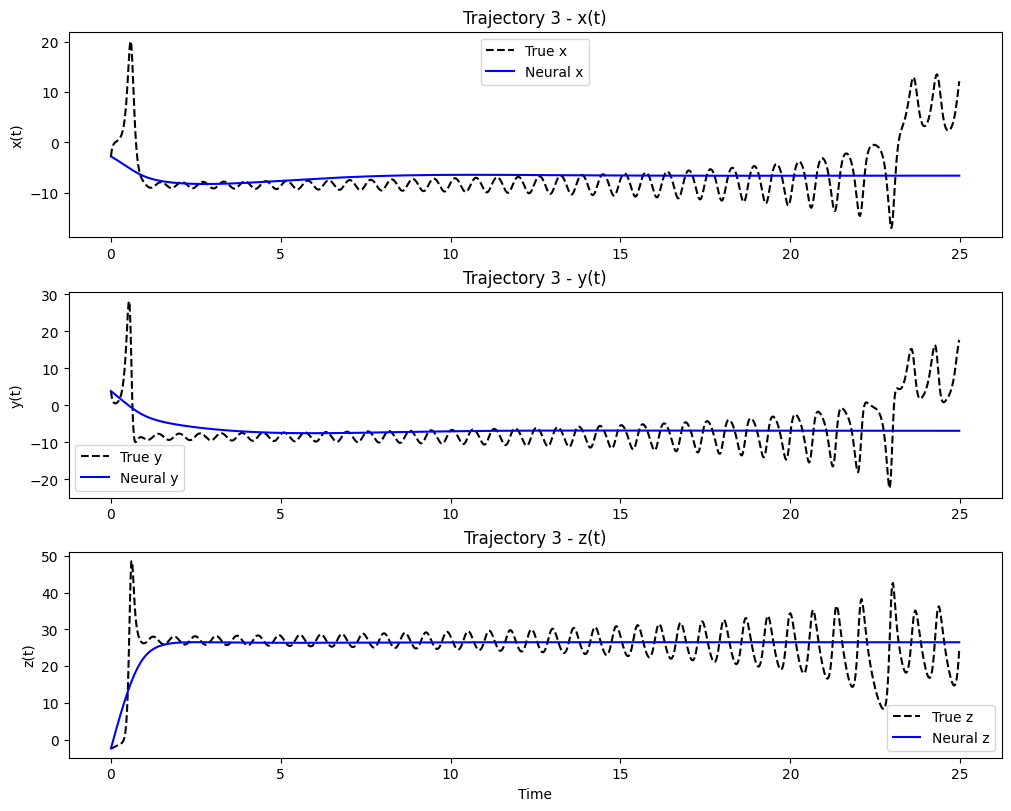

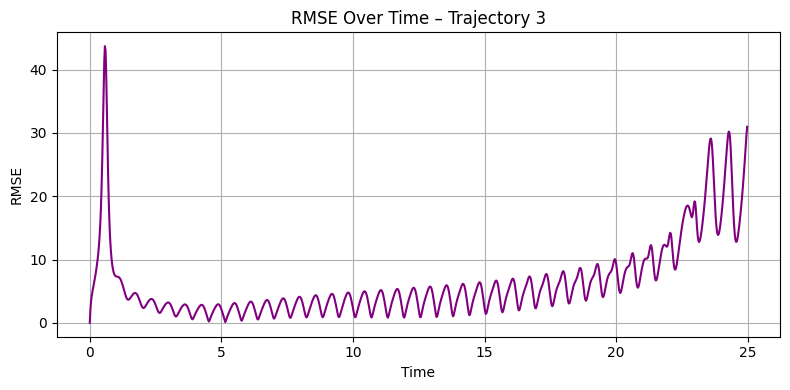

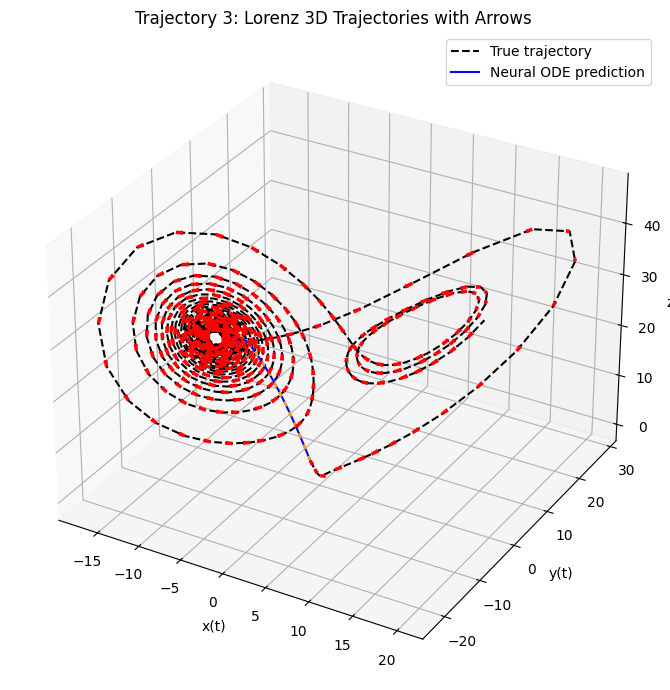


=== Lorenz Trajectory 4/10 ===
Epoch 0, Loss = 32.955803
Epoch 200, Loss = 1.046633
Epoch 400, Loss = 0.904715
Epoch 600, Loss = 0.839612
Epoch 800, Loss = 0.802260
Epoch 1000, Loss = 0.778025
Epoch 1200, Loss = 0.760738
Epoch 1400, Loss = 0.747363
Epoch 1600, Loss = 0.736281
Epoch 1800, Loss = 0.726588


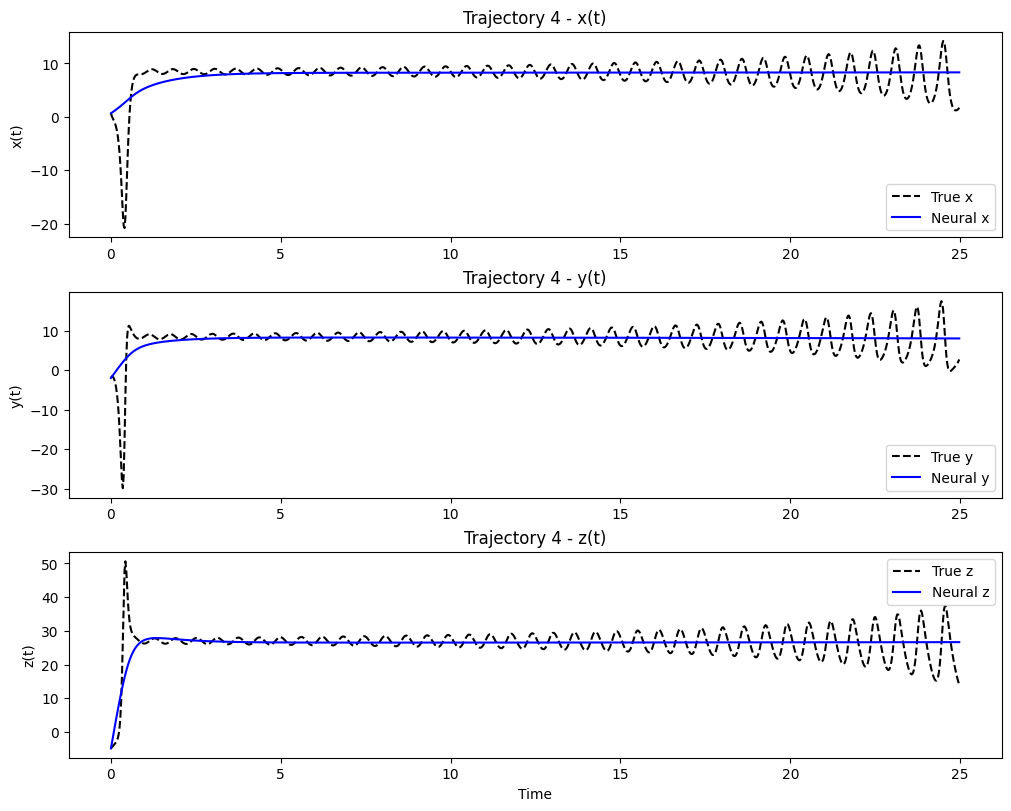

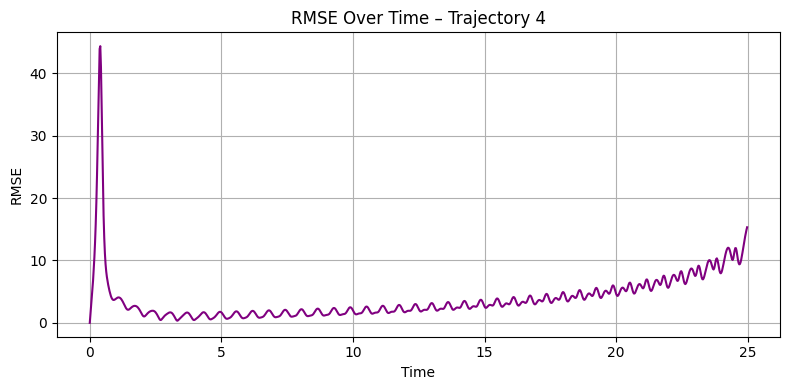

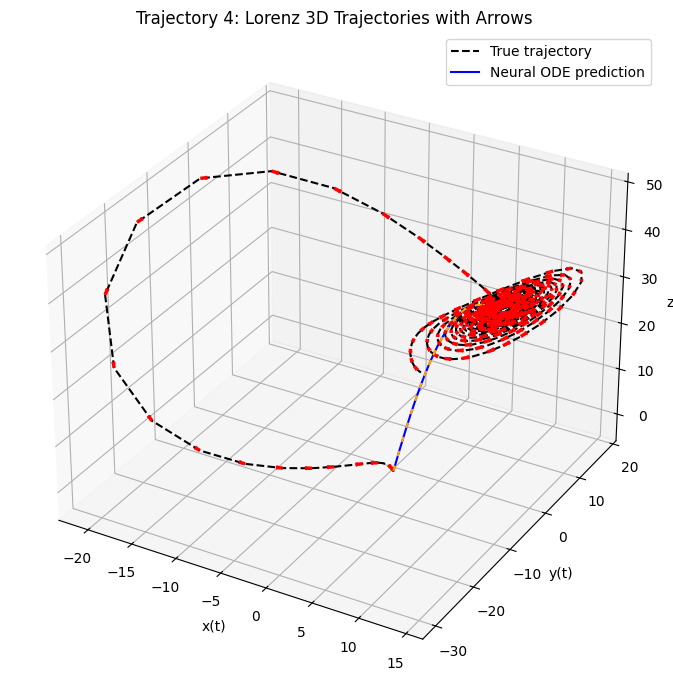


=== Lorenz Trajectory 5/10 ===
Epoch 0, Loss = 6.726100
Epoch 200, Loss = 0.923305
Epoch 400, Loss = 0.876370
Epoch 600, Loss = 0.853230
Epoch 800, Loss = 0.842660
Epoch 1000, Loss = 0.831605
Epoch 1200, Loss = 0.989533
Epoch 1400, Loss = 0.982213
Epoch 1600, Loss = 0.975304
Epoch 1800, Loss = 0.958741


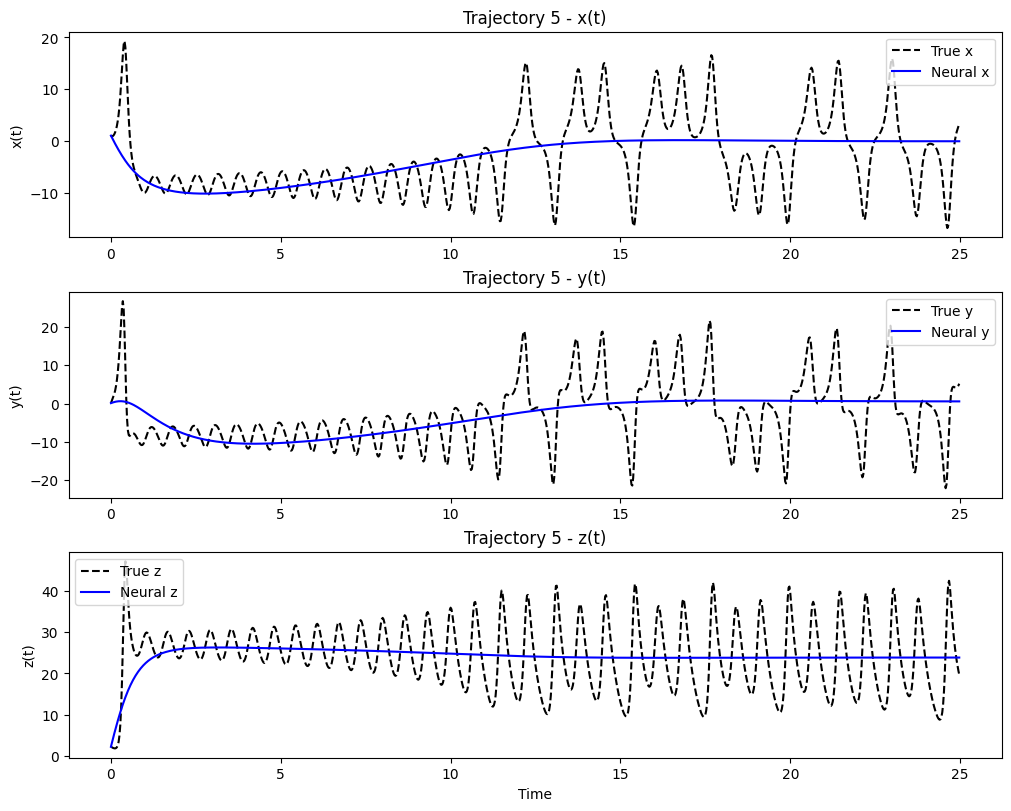

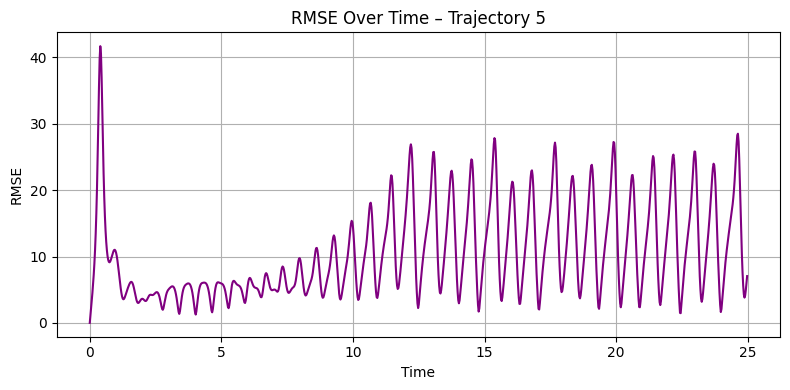

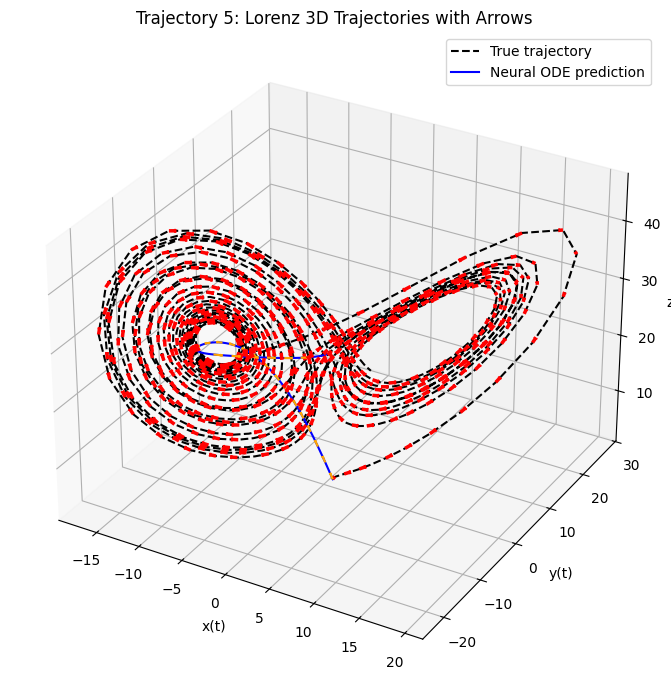


=== Lorenz Trajectory 6/10 ===
Epoch 0, Loss = 82.086617
Epoch 200, Loss = 1.244386
Epoch 400, Loss = 1.127860
Epoch 600, Loss = 1.067292
Epoch 800, Loss = 1.031900
Epoch 1000, Loss = 1.007380
Epoch 1200, Loss = 0.988756
Epoch 1400, Loss = 0.973896
Epoch 1600, Loss = 0.961636
Epoch 1800, Loss = 0.951261


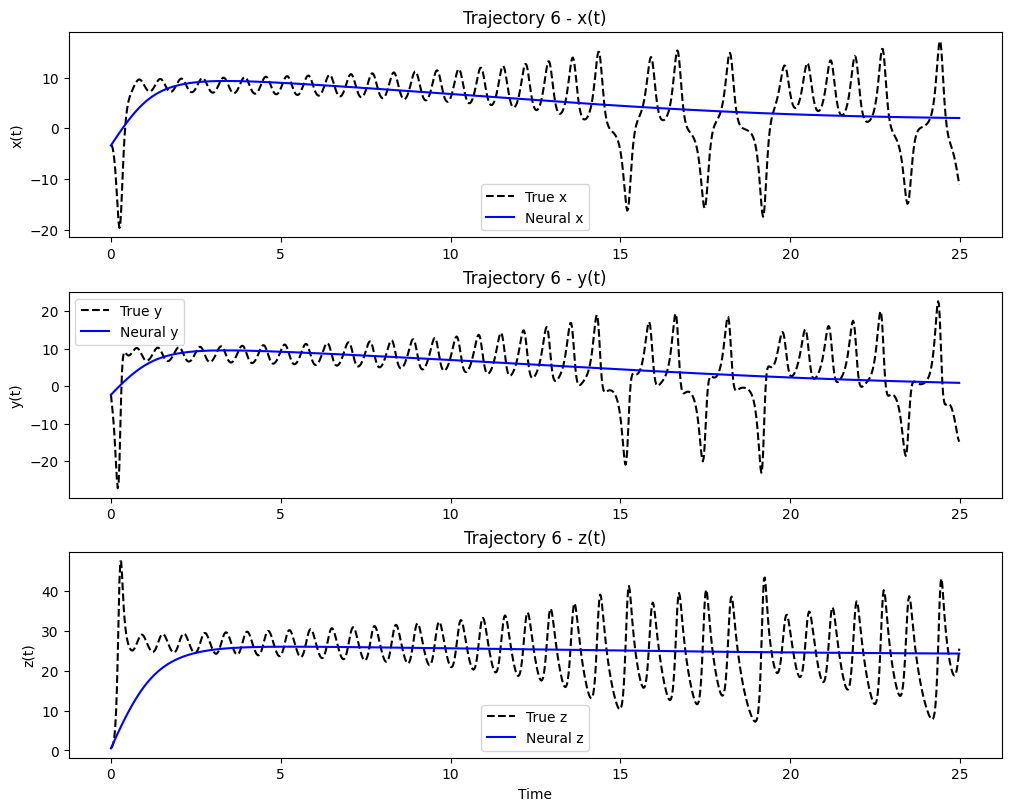

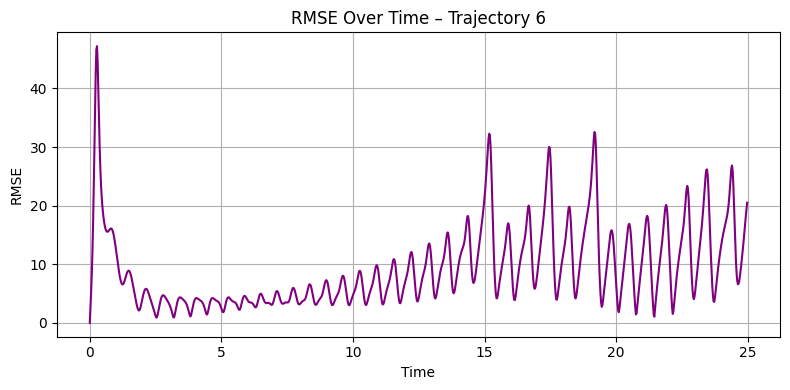

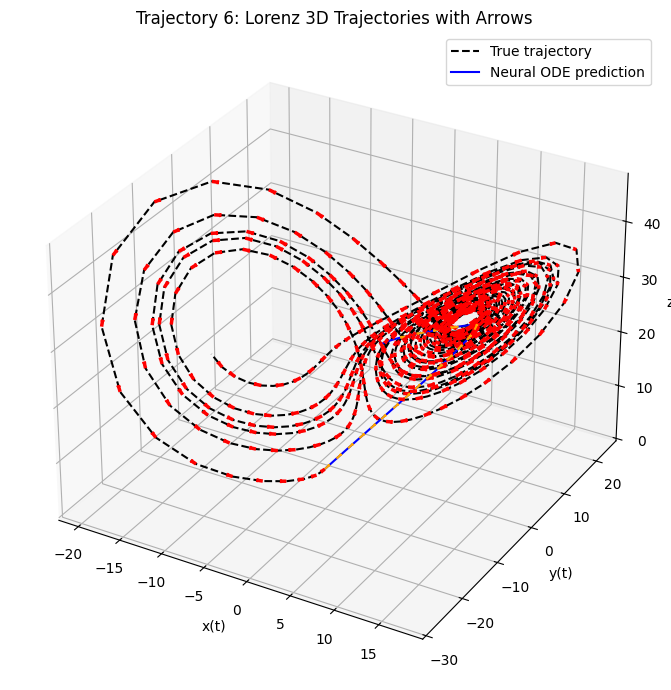


=== Lorenz Trajectory 7/10 ===
Epoch 0, Loss = 31.147745
Epoch 200, Loss = 1.064574
Epoch 400, Loss = 0.935718
Epoch 600, Loss = 0.872622
Epoch 800, Loss = 0.853284
Epoch 1000, Loss = 0.843806
Epoch 1200, Loss = 0.837038
Epoch 1400, Loss = 0.831697
Epoch 1600, Loss = 0.827200
Epoch 1800, Loss = 0.823243


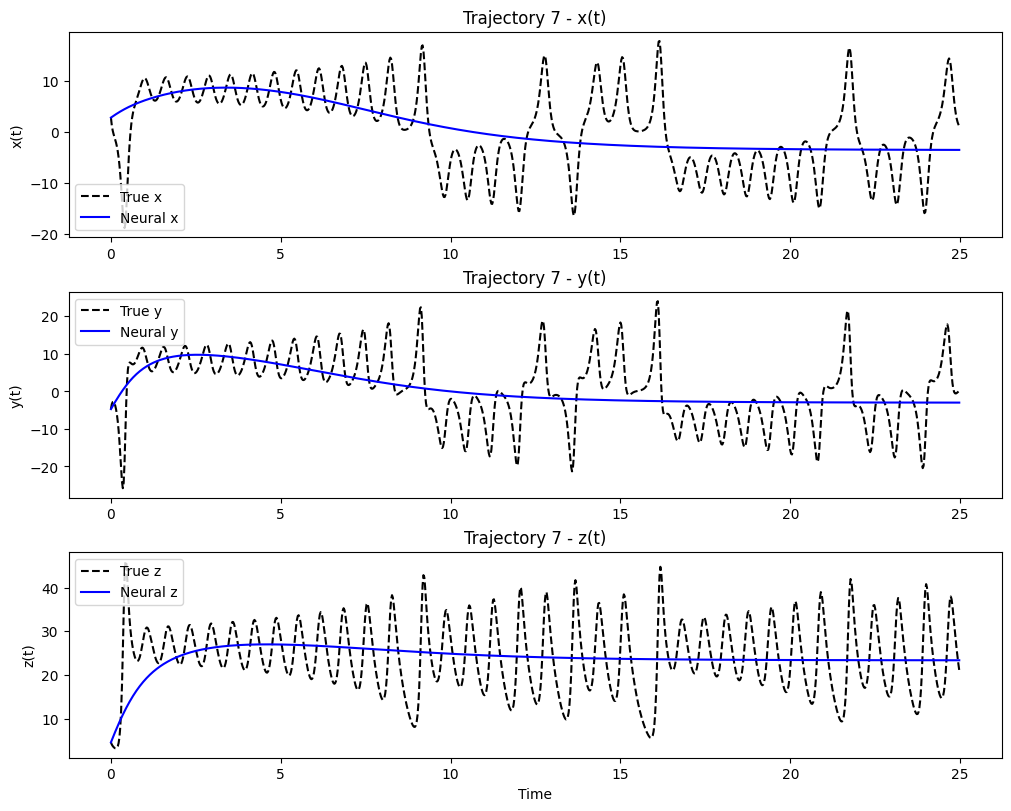

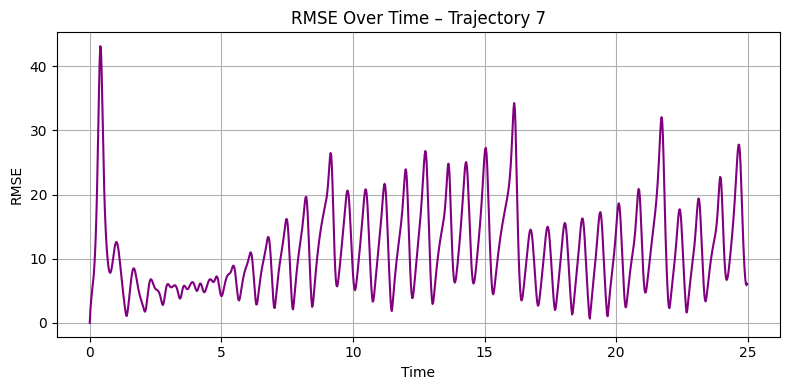

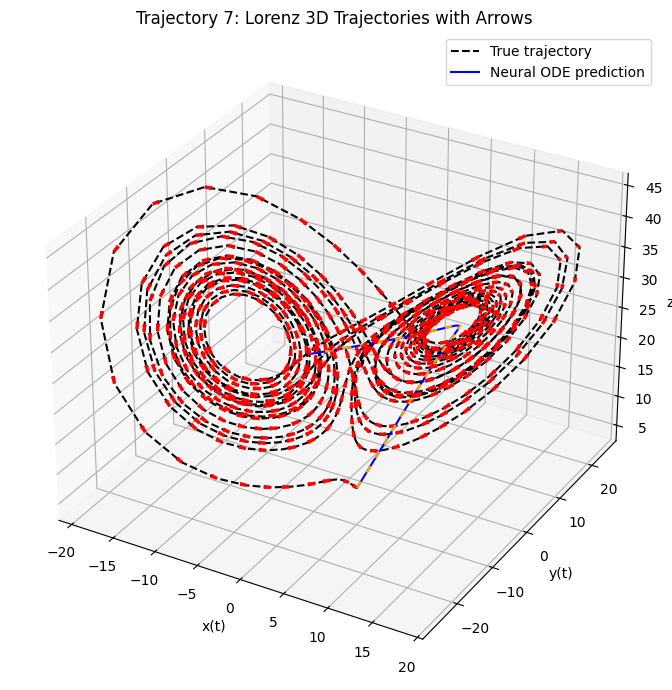


=== Lorenz Trajectory 8/10 ===
Epoch 0, Loss = 52.311604
Epoch 200, Loss = 1.054451
Epoch 400, Loss = 0.955649
Epoch 600, Loss = 0.908682
Epoch 800, Loss = 0.890737
Epoch 1000, Loss = 0.887251
Epoch 1200, Loss = 0.871314
Epoch 1400, Loss = 0.865055
Epoch 1600, Loss = 0.858535
Epoch 1800, Loss = 0.859707


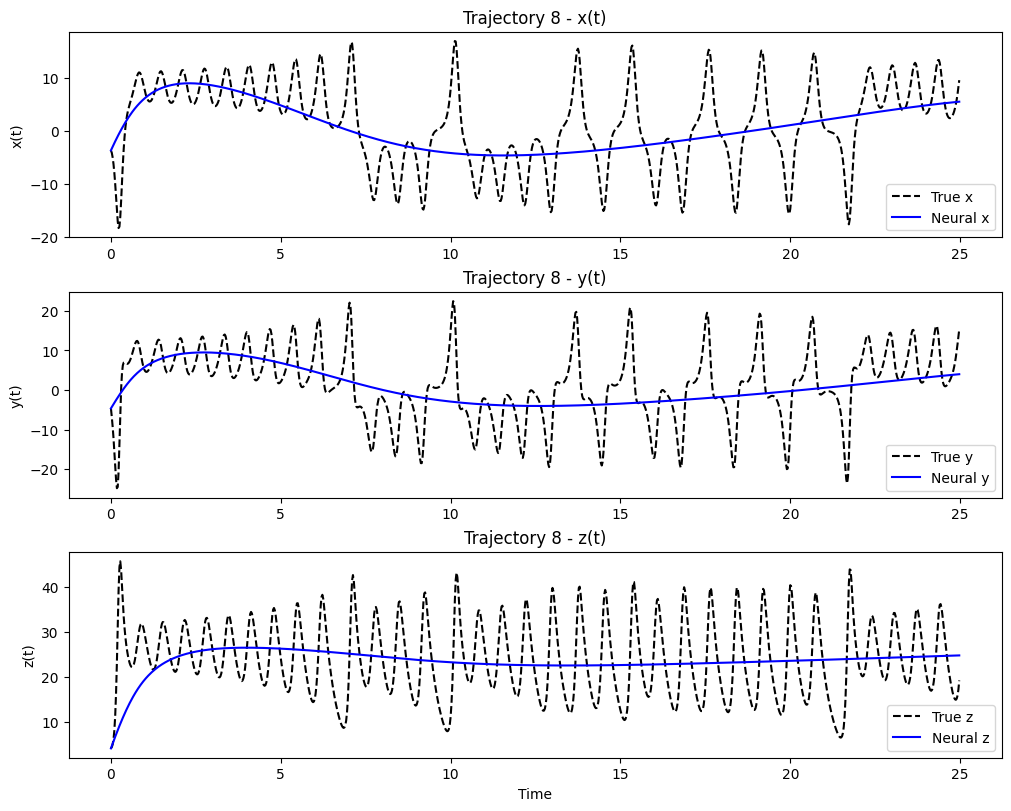

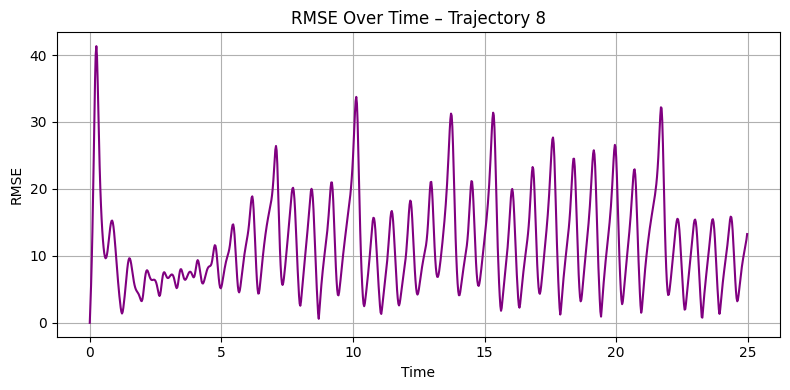

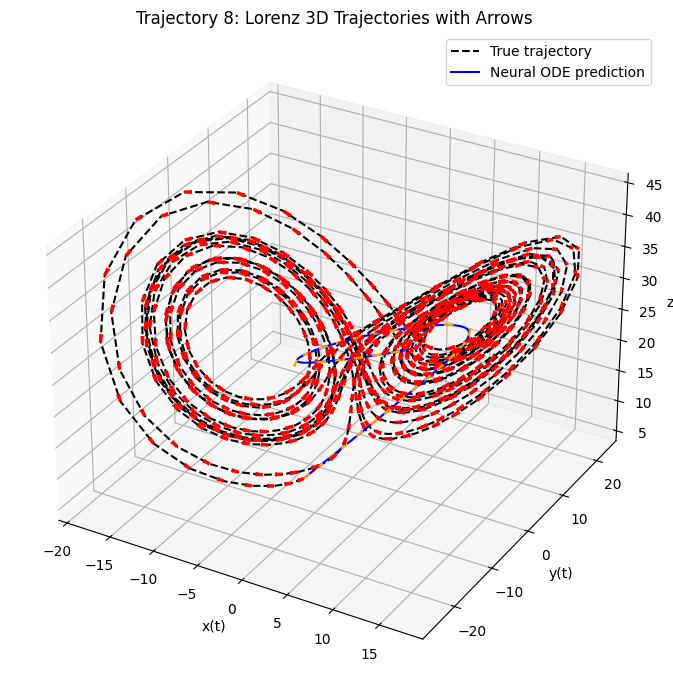


=== Lorenz Trajectory 9/10 ===
Epoch 0, Loss = 35.902538
Epoch 200, Loss = 1.502684
Epoch 400, Loss = 1.190198
Epoch 600, Loss = 1.069462
Epoch 800, Loss = 0.994056
Epoch 1000, Loss = 0.941154
Epoch 1200, Loss = 0.901462
Epoch 1400, Loss = 0.870171
Epoch 1600, Loss = 0.844456
Epoch 1800, Loss = 0.822527


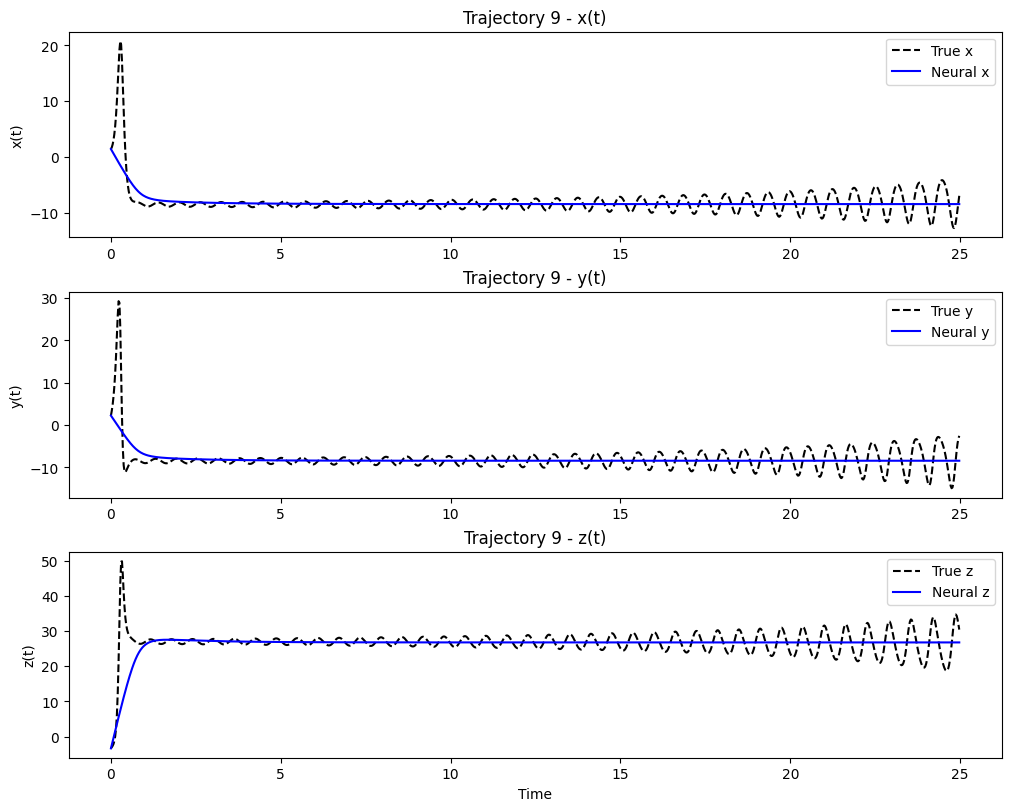

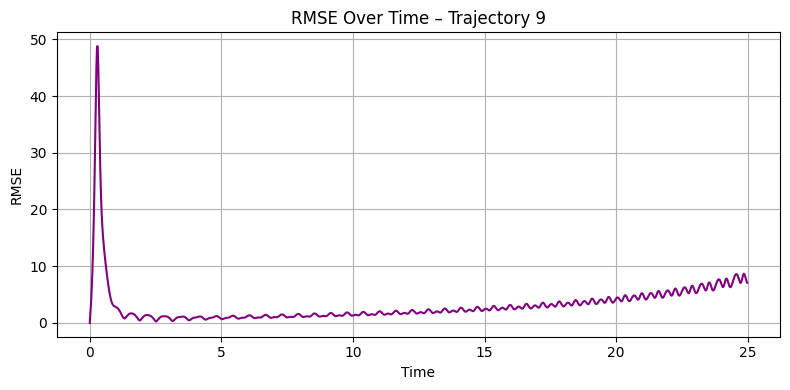

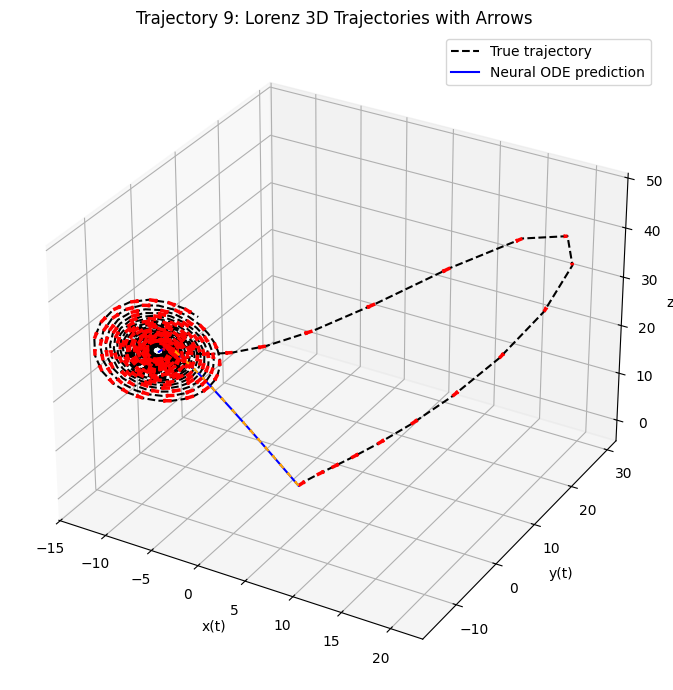


=== Lorenz Trajectory 10/10 ===
Epoch 0, Loss = 24.004305
Epoch 200, Loss = 1.077520
Epoch 400, Loss = 0.992892
Epoch 600, Loss = 0.872926
Epoch 800, Loss = 0.845127
Epoch 1000, Loss = 0.828479
Epoch 1200, Loss = 0.821300
Epoch 1400, Loss = 0.813247
Epoch 1600, Loss = 0.809069
Epoch 1800, Loss = 0.805679


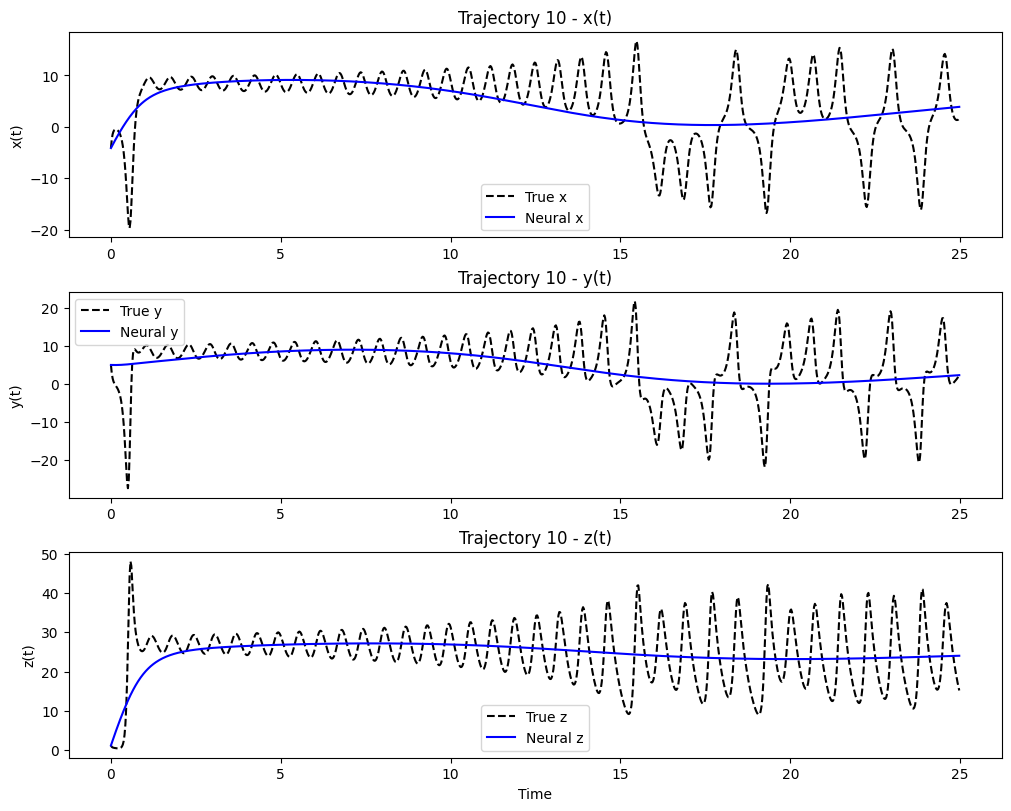

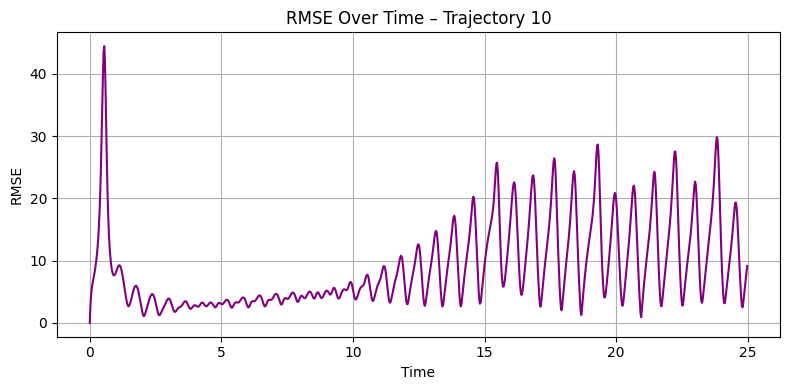

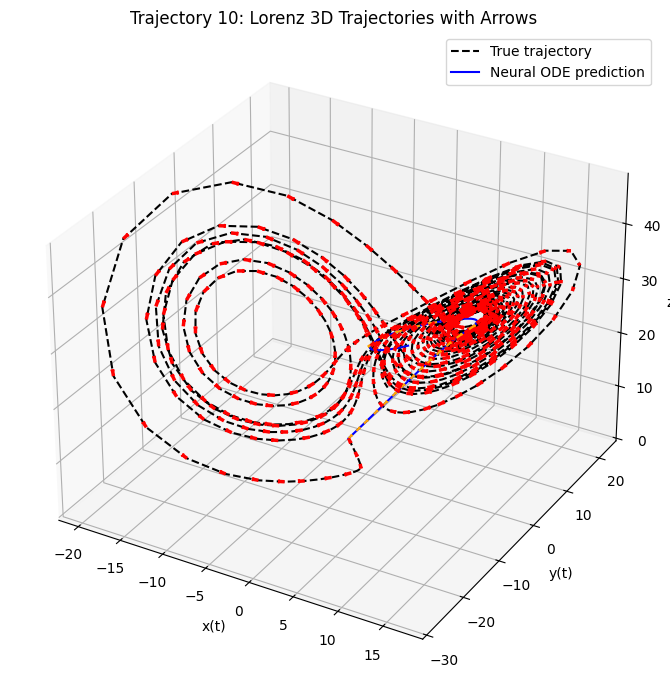

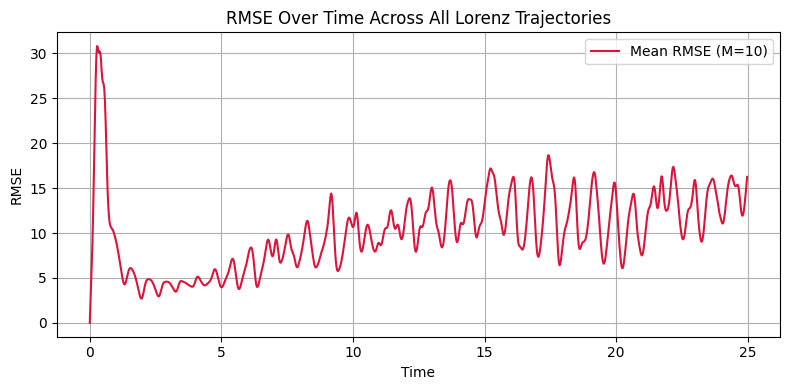

In [15]:
data = np.load("data/lorenz.npz", allow_pickle=True)["trajectories"]
M = len(data)
NUM_EPOCHS = 2000
LEARNING_RATE = 1e-3

true_trajectories = []
pred_trajectories = []

for i in range(M):
    print(f"\n=== Lorenz Trajectory {i+1}/{M} ===")
    traj_data = data[i]
    z_data_np = traj_data["traj"]
    t_eval_np = traj_data["t"]

    z_data = torch.tensor(z_data_np, dtype=torch.float32)
    t_eval = torch.tensor(t_eval_np, dtype=torch.float32)

    # Train model
    model_neural = LZNeuralODE()
    trained_neural, scaler = train(model_neural, t_eval, z_data, n_epochs=NUM_EPOCHS, lr=LEARNING_RATE)

    model_path = f"models/lorenz_neural_model_{i}.pt"
    torch.save({
        'model_state_dict': trained_neural.state_dict(),
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
    }, model_path)


    # Predict
    with torch.no_grad():
        z0_scaled = torch.tensor(scaler.transform(z_data[[0]].numpy()), dtype=torch.float32)[0]
        pred_scaled = odeint(trained_neural, z0_scaled, t_eval, method='dopri5')
        pred = torch.tensor(scaler.inverse_transform(pred_scaled.numpy()), dtype=torch.float32)

    # Store for RMSE aggregate
    true_trajectories.append(z_data.numpy())
    pred_trajectories.append(pred.numpy())

    # Plot x/y/z dynamics
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)
    axs[0].plot(t_eval_np, z_data_np[:, 0], 'k--', label='True x')
    axs[0].plot(t_eval_np, pred[:, 0], 'b', label='Neural x')
    axs[0].set_ylabel("x(t)")
    axs[0].legend()
    axs[0].set_title(f"Trajectory {i+1} - x(t)")

    axs[1].plot(t_eval_np, z_data_np[:, 1], 'k--', label='True y')
    axs[1].plot(t_eval_np, pred[:, 1], 'b', label='Neural y')
    axs[1].set_ylabel("y(t)")
    axs[1].legend()
    axs[1].set_title(f"Trajectory {i+1} - y(t)")

    axs[2].plot(t_eval_np, z_data_np[:, 2], 'k--', label='True z')
    axs[2].plot(t_eval_np, pred[:, 2], 'b', label='Neural z')
    axs[2].set_ylabel("z(t)")
    axs[2].legend()
    axs[2].set_title(f"Trajectory {i+1} - z(t)")
    axs[2].set_xlabel("Time")

    plt.show()

    # Plot RMSE for this trajectory
    rmse_i = np.sqrt(np.sum((pred.numpy() - z_data_np) ** 2, axis=1))
    plt.figure(figsize=(8, 4))
    plt.plot(t_eval_np, rmse_i, color='purple')
    plt.title(f"RMSE Over Time – Trajectory {i+1}")
    plt.xlabel("Time")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 3D Quiver Plot with Directional Arrows ---
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    min_arrow_spacing = 2.0
    pred_np = pred.numpy()

    arrow_indices_true = sample_arrows_by_distance(z_data_np, min_arrow_spacing)
    arrow_indices_pred = sample_arrows_by_distance(pred_np, min_arrow_spacing)

    for j in arrow_indices_true[:-1]:
        p0 = z_data_np[j]
        p1 = z_data_np[j + 1]
        direction = p1 - p0
        ax.quiver(*p0, *direction, color='r', length=1.0, normalize=True, linewidth=2.5)

    for j in arrow_indices_pred[:-1]:
        p0 = pred_np[j]
        p1 = pred_np[j + 1]
        direction = p1 - p0
        ax.quiver(*p0, *direction, color='orange', length=1.0, normalize=True, linewidth=1.5)

    ax.plot(z_data_np[:, 0], z_data_np[:, 1], z_data_np[:, 2], 'k--', label='True trajectory')
    ax.plot(pred_np[:, 0], pred_np[:, 1], pred_np[:, 2], 'b', label='Neural ODE prediction')

    ax.set_xlabel("x(t)")
    ax.set_ylabel("y(t)")
    ax.set_zlabel("z(t)")
    ax.set_title(f"Trajectory {i+1}: Lorenz 3D Trajectories with Arrows")
    ax.legend()

    plt.tight_layout()
    plt.show()

# === Overall RMSE Across All M ===
rmse_over_time = compute_rmse_over_time(true_trajectories, pred_trajectories)

plt.figure(figsize=(8, 4))
plt.plot(t_eval_np, rmse_over_time, label="Mean RMSE (M=10)", color='crimson')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title("RMSE Over Time Across All Lorenz Trajectories")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save the RMSE for Lorenz trajectories
np.savez("data/lorenz_neural_rmse.npz", rmse=rmse_t, t=t_eval_np, label="Neural ODE")